In [139]:
import matplotlib.pyplot as plt
import matplotlib
import requests
import re
import pandas as pd
import sys
import warnings
import numpy as np
import fbprophet
import datetime
import dateutil.parser
from bs4 import BeautifulSoup
from six import string_types

warnings.filterwarnings('ignore')
%matplotlib inline 

In [182]:
class Forecaster:

    _BASE_URL = "https://www.hockey-reference.com"

    ###########
    # Constructor
    ###########
    def __init__(self, player, player_abbr):
        self.player = player
        self.player_abbr = player_abbr
        self.goalie = False
        
        self.player_log = self._get_training_data(self.player, self.player_abbr)
        
        # Minimum and maximum date in range
        self.min_date = min(self.player_log['DATE'])
        self.max_date = max(self.player_log['DATE'])
        
        print(f"min_date={self.min_date} max_date={self.max_date}")

        # Find max and min fantasy points and days on which they occurred
        self.max_dfs_point = np.max(self.player_log['DK'])
        self.min_dfs_point = np.min(self.player_log['DK'])
        print(f"max_dfs_point={self.max_dfs_point} min_dfs_point={self.min_dfs_point}")
        self.min_dfs_point_date = self.player_log[self.player_log['DK'] == self.min_dfs_point]['DATE']
        self.min_dfs_point_date = self.min_dfs_point_date[self.min_dfs_point_date.index[0]]
        self.max_dfs_point_date = self.player_log[self.player_log['DK'] == self.max_dfs_point]['DATE']
        self.max_dfs_point_date = self.max_dfs_point_date[self.max_dfs_point_date.index[0]]
        print(f"min_dfs_point_date={self.min_dfs_point_date} max_dfs_point_date={self.max_dfs_point_date}")
        # The most recent fantasy points scored
        #self.most_recent_dfs_points = self.player_log.ix[len(self.player_log)-1, 'DK']
        self.most_recent_dfs_points = self.player_log['DK'].iloc[-1]
        print(f"most_recent_dfs_points={self.most_recent_dfs_points}")
        # Number of years of data to train on
        self.training_years = 3

        # Prophet parameters
        # Default prior from library
        self.changepoint_prior_scale = 0.05 
        self.weekly_seasonality = False
        self.daily_seasonality = False
        self.monthly_seasonality = True
        self.yearly_seasonality = True
        self.changepoints = None
        
        print('{} Stocker Initialized. Data covers {} to {}.'.format(self.player,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
        
    #############
    # This will simulate a static variable.
    #############
    @property
    def BASE_URL(self):
        return self._BASE_URL

    
    ###########
    # Return the dataframe trimmed to the specified range.
    ###########
    def make_df(self, start_date, end_date, df=None):
        
        # Default is to use the object player data
        if not df:
            df = self.player_log.copy()
            
        # Validate whether start and end dates are in data
        start_in = True
        end_in = True
        
        # Record if start and end dates are in dataframe
        if (start_date not in list(df['DATE'])):
            start_in = False
        if (end_date not in list(df['DATE'])):
            end_in = False

        print(f"start_date={start_date} end_date={end_date}")
        print(f"end_in={end_in} start_in={start_in}")      
        # If both are NOT in data, round both
        if (not end_in) & (not start_in):
            trim_df = df[(df['DATE'] >= start_date.date()) & 
                         (df['DATE'] <= end_date.date())]
        else:
            # If both are in dataframe, round neither
            if (end_in) & (start_in):
                trim_df = df[(df['DATE'] >= start_date.date()) & 
                             (df['DATE'] <= end_date.date())]
            else:
                # If only start is missing, round start
                if (not start_in):
                    trim_df = df[(df['DATE'] > start_date.date()) & 
                                 (df['DATE'] <= end_date.date())]
                # If only end is imssing round end
                elif (not end_in):
                    trim_df = df[(df['DATE'] >= start_date.date()) & 
                                 (df['DATE'] < end_date.date())]
        return trim_df
        
    ##########
    # Basic Historical Plots and Statistics
    ##########   
    def plot_points(self, start_date=None, end_date=None, stats=['DK'], plot_type='basic'):
        
        self.reset_plot()

        if start_date == None:
            start_date = self.min_date
        if end_date == None:
            end_date = self.max_date
            
        points_plot = self.make_df(start_date, end_date)
        
        colors = ['r', 'b', 'g', 'y', 'c', 'm']
        
        for i, stat in enumerate(stats):
            
            stat_min = min(points_plot[stat])
            stat_max = max(points_plot[stat])

            stat_avg = np.mean(points_plot[stat])
            date_stat_min = points_plot[points_plot[stat] == stat_min]['DATE']
            date_stat_min = date_stat_min[date_stat_min.index[0]]
            date_stat_max = points_plot[points_plot[stat] == stat_max]['DATE']
            date_stat_max = date_stat_max[date_stat_max.index[0]]
            
            #self.player_log['DK'].iloc[-1]
            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.player_log[stat].iloc[-1], self.max_date.date()))
            
            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                plt.style.use('fivethirtyeight');
                
                if stat == 'Daily Change':
                    plt.plot(points_plot['DATE'], 100 * points_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(points_plot['DATE'], 100 * (points_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xticks(rotation='vertical')
                plt.xlabel('Date') 
                plt.ylabel('Change Relative to Average (%)') 
                plt.title('%s Points History' % self.player); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 

            # Stat y-axis
            elif plot_type == 'basic':
                plt.style.use('fivethirtyeight');
                plt.plot(points_plot['DATE'], points_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xticks(rotation='vertical')
                plt.xlabel('DATE')
                plt.ylabel('DK PTS')
                plt.title('%s Points History' % self.player) 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 
      
        plt.show();
        
    ##########
    # Reset the plotting parameters to clear style formatting
    # Not sure if this should be a static method
    ##########
    @staticmethod
    def reset_plot():
        
        # Restore default parameters
        matplotlib.rcParams.update(plt.rcParamsDefault)

        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (8, 5)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'

    #########
    # private function to fetch training data
    #########
    def _get_training_data(self, player, extension):
        letter = extension[:1]
        player_url = f"{self.BASE_URL}/players/{letter}/{extension}.html"

        print("getting training data for " + player + " ...")
        print(player_url)

        # Follow the URL and extract the additional data needed
        r = requests.get(player_url, verify=False)

        b = BeautifulSoup(r.text, "html.parser")
        
        uls = b.find_all("ul")

        game_logs = {}

        for ul in uls:
            a = ul.find_all("a", href=True)
            for link in a:
                # regex = ".*/gamelog/(2017|2018|2019)"
                regex = ".*/gamelog/(2017|2018|2019)"    
                if re.search(regex, link['href']):
                    if re.search(".*/2016", link['href']):
                        season = 2016
                    elif re.search("./2017", link['href']):
                        season = 2017
                    elif re.search("./2018", link['href']):
                        season = 2018
                    elif re.search("./2019", link['href']):
                        season = 2019
                    value = link['href']
                    key = season
                    game_logs[key]=value

            player_log = pd.DataFrame()
            
        for key in game_logs:
            url = f"{self.BASE_URL}{game_logs[key]}"
            try:
                print(f"url={url} key={key} player={player} goalie={self.goalie}")
                buffer_df = self._get_log_data(self, url, key, player, self.goalie)
                player_log = player_log.append(buffer_df)
            except Exception :
                print(f"Unexpected error: {sys.exc_info()[0]}")
                print("ERROR: This is not an active player.")
                buffer_df = pd.DataFrame()
                break
        if not self.goalie:
            try:
                player_log.BLK[player_log.BLK == ''] = 0
            except:
                pass
            
        player_log = player_log.apply(pd.to_numeric, downcast='float', errors='ignore')
        player_log.fillna(0.0, inplace=True)
        player_log['DATE'] = pd.to_datetime(player_log['DATE'].apply(self.convert_to_date))
        player_log['ds'] = player_log['DATE']
        player_log['DK'] = player_log.apply(self._calculate_draftkings_score, axis=1)
        # This is needed for modeling.
        player_log['y'] = player_log['DK']
        player_log['TOI_CONV'] = player_log.apply(self._convert_total_on_ice, axis=1)
        player_log['ESP_PG'] = (player_log['EV_G'].astype(float) + player_log['EV_A'].astype(float)) / 60.0
        player_log['PPP_PG'] = (player_log['PP_G'].astype(float) + player_log['PP_A'].astype(float)) / 60.0
        player_log['PPG'] = (player_log.PTS/player_log.TOI_CONV) * 60
        
        return player_log

    @staticmethod
    def convert_to_date(value):
        if isinstance(value, string_types) and re.search(r'^\d{4}-\d{2}-\d{2}$', value):
            return dateutil.parser.parse(value).date()
        elif isinstance(value, string_types) and re.search(r'^\d{4}-\d{2}-\d{2}T[\d:\.]+Z$', value):
            # convert to datetime.datetime, default timezone is utc
            return dateutil.parser.parse(value)
        else:
            return value
    
    ############
    # Convert string for total on ice to time
    ############
    @staticmethod
    def _convert_total_on_ice(row):
        t = row.TOI
        m, s = t.split(':')

        return float((int(m) * 1) + (int(s)/60))
    """
    Point Scoring

    Points will be scored in the same way for all DraftKings daily fantasy hockey contests, according to the following schedule:

    Goal Scored: 3 Points
    Assist: 2 Points
    Shot on Goal: 0.5 Points
    Blocked Shot: 0.5 Points
    Short Handed Point Bonus (Goal/Assist): 1 Points
    Shootout Goal: 0.2 Points
    Hat Trick Bonus: 1.5 Points

    In addition, goalies will score points for the following actions:

    Team Win: +3 Points
    Save: +0.2 Points
    Goal Allowed: -1 Points
    Shutout Bonus: +2 Points
    """
    @staticmethod
    def _calculate_draftkings_score(row):
        hat_trick_bonus = 0.0
        if row.G >= 3.0:
            hat_trick_bonus = 1.5
        return (row.G * 3.0) + (row.A * 2.0) + (row.S * 0.5) + (row.BLK * 0.5) + (row.SH_G * 1.0) + (row.SH_A + 1.0) + hat_trick_bonus
    
    ###########
    # Private method to scrape game log data
    ###########
    @staticmethod
    def _get_log_data(self, gamelogs_url, season, player, goalie):
        url = gamelogs_url
        r = requests.get(url, verify=False)
        b = BeautifulSoup(r.text, "html.parser")
        
        # Find tables tagged with id=gamelogs
        table = b.find_all('table', {'id': 'gamelog'})
        rows = []
        for tbl in table:
            for tr in tbl.find_all('tr'):
                row = []
                for td in tr.find_all('td'):
                    row.append(td.text.replace('\n',''))
                if not goalie:
                    if len(row) == 28 and row[0] != "":
                        rows.append(row)
                else:
                    if len(row) == 15 and row[0] != "":
                        rows.append(row)
        if not goalie:
            log_data = pd.DataFrame(rows, columns=['DATE', 'GAME', 'AGE', 'TM', 'HOA',
                                                'OPP', 'RSLT', 'G', 'A', 'PTS',
                                                'PM', 'PIM', 'EV_G', 'PP_G',
                                                'SH_G', 'GW_G', 'EV_A', 'PP_A',
                                                'SH_A', 'S', 'S_PCT', 'SHFT',
                                                'TOI', 'HIT', 'BLK', 'FOW',
                                                'FOL', 'FO_PCT'])
        else:
            log_data = pd.DataFrame(rows, columns=['DATE', 'GAME', 'AGE', 'TM', 'HOA',
                                                'OPP', 'RSLT', 'DEC', 'GA', 'SA', 
                                                'SV', 'SV_PCT', 'SO', 'PIM', 'TOI'])

        log_data['season'] = season
        log_data['name'] = player
        log_data.head()
        return log_data
    
    #############
    # Create a prophet model without training
    #############
    def create_model(self):
        
        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,
                                 weekly_seasonality=self.weekly_seasonality,
                                 yearly_seasonality=self.yearly_seasonality,
                                 changepoint_prior_scale=self.changepoint_prior_scale,
                                 changepoints=self.changepoints)
        
        if self.monthly_seasonality:
            # Add monthly seasonality
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            
        return model
    
    #############
    # Basic prophet model for specified number of days  
    #############
    def create_prophet_model(self, days=0, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on point history for self.training_year number of years
        point_history = self.player_log[self.player_log['DATE'] > (self.max_date - pd.DateOffset(years=self.training_years)).date()]
        
        model.fit(point_history)
        
        future = model.make_future_dataframe(periods=days, freq='D')
        future = model.predict(future)
        
        if days > 0:
            # Print the predicted points
            print('Predicted Points on {} = ${:.2f}'.format(
                future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))

            title = '%s Historical and Predicted Points'  % self.player
        else:
            title = '%s Historical and Modeled Points' % self.player
            
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(point_history['ds'], point_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Points');
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title(title);
        plt.show()
        
        return model, future
    
    ##############
    # Evalue prediction model for 1 year
    ##############
    def evaluate_prediction(self, start_date=None, end_date=None, nshares=None):
        # Default start date is one year before end of data
        # Default end date is end date of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=1)
        if end_date is None:
            end_date = self.max_date
            
        # Training data starts self.training_years years before start_date and goes up to start date
        train = self.player_log[(self.player_log['DATE'] < start_date.date()) &
                               (self.player_log['DATE'] > (start_date - pd.DateOffset(years=self.training_years)).date())]
        
        # Testing data is specified in the range
        test = self.player_log[(self.player_log['DATE'] >= start_date.date()) & (self.player_log['DATE'] <= end_date.date())]
        
        # Create and train the model
        model = self.create_model()
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')

        train = pd.merge(train, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

        # Calculate mean absolute error
        test_errors = abs(test['y'] - test['yhat'])
        test_mean_error = np.mean(test_errors)

        train_errors = abs(train['y'] - train['yhat'])
        train_mean_error = np.mean(train_errors)

        # Calculate percentage of time actual value within prediction range
        test['in_range'] = False

        for i in test.index:
            if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
                test.ix[i, 'in_range'] = True

        in_range_accuracy = 100 * np.mean(test['in_range'])
        
        if not nshares:

            # Date range of predictions
            print('\nPrediction Range: {} to {}.'.format(start_date.date(),
                end_date.date()))

            # Final prediction vs actual value
            print('\nPredicted points on {} = {:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
            print('Actual points on    {} = {:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))

            print('Average Absolute Error on Training Data = {:.2f}.'.format(train_mean_error))
            print('Average Absolute Error on Testing  Data = {:.2f}.\n'.format(test_mean_error))

            # Direction accuracy
            print('When the model predicted an increase, the points increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the points decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))


             # Reset the plot
            self.reset_plot()
            
            # Set up the plot
            fig, ax = plt.subplots(1, 1)

            # Plot the actual values
            ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            
            # Plot the predicted values
            ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

            # Plot the uncertainty interval as ribbon
            ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                           facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

            # Put a vertical line at the start of predictions
            plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                       linestyles='dashed', label = 'Prediction Start')

            # Plot formatting
            plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
            plt.grid(linewidth=0.6, alpha = 0.6)
                       
            plt.title('{} Model Evaluation from {} to {}.'.format(self.player,
                start_date.date(), end_date.date()));
            plt.show();

In [183]:
forecaster = Forecaster('Alex Ovechkin', 'ovechal01')

getting training data for Alex Ovechkin ...
https://www.hockey-reference.com/players/o/ovechal01.html
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2017 key=2017 player=Alex Ovechkin goalie=False
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2018 key=2018 player=Alex Ovechkin goalie=False
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2019 key=2019 player=Alex Ovechkin goalie=False
min_date=2016-10-13 00:00:00 max_date=2019-02-21 00:00:00
max_dfs_point=18.5 min_dfs_point=1.0
min_dfs_point_date=2017-02-09 00:00:00 max_dfs_point_date=2017-10-07 00:00:00
most_recent_dfs_points=5.5
Alex Ovechkin Stocker Initialized. Data covers 2016-10-13 to 2019-02-21.



Prediction Range: 2018-02-21 to 2019-02-21.

Predicted points on 2019-02-20 = 5.74.
Actual points on    2019-02-18 = 8.50.

Average Absolute Error on Training Data = 2.26.
Average Absolute Error on Testing  Data = 3.23.

When the model predicted an increase, the points increased 47.73% of the time.
When the model predicted a  decrease, the points decreased  41.67% of the time.

The actual value was within the 80% confidence interval 69.14% of the time.


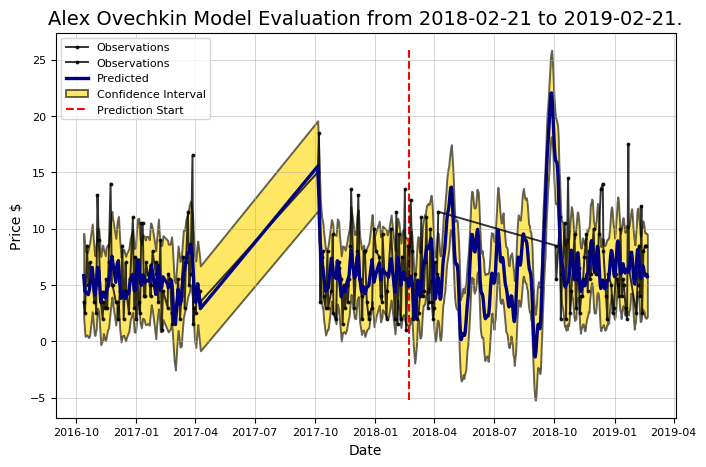

In [184]:
forecaster.evaluate_prediction()

Predicted Points on 2019-03-23 = $7.07


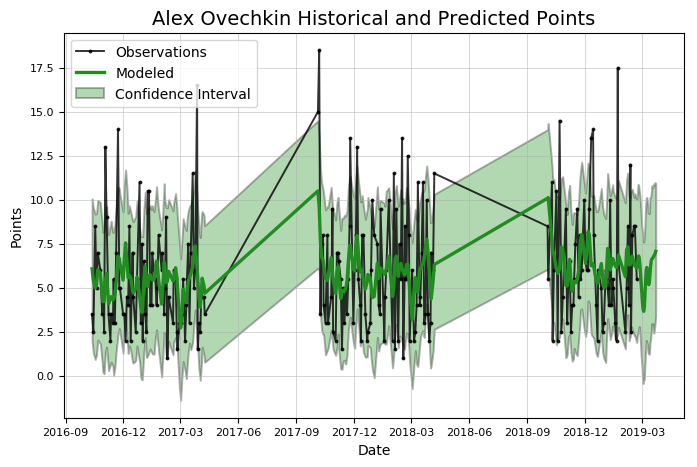

In [185]:
model, model_data = forecaster.create_prophet_model(days=30)

start_date=2016-10-13 00:00:00 end_date=2019-02-21 00:00:00
end_in=True start_in=True
Maximum DK = 18.50 on 2017-10-07 00:00:00.
Minimum DK = 1.00 on 2017-02-09 00:00:00.
Current DK = 5.50 on 2019-02-21.



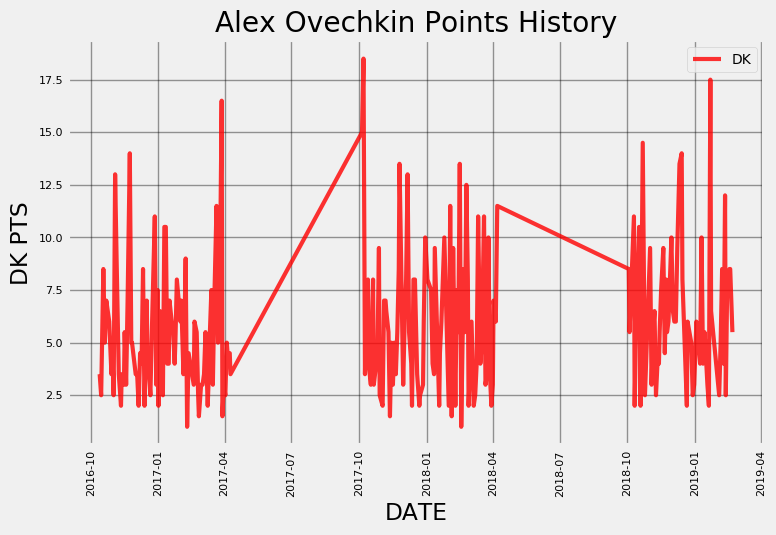

In [186]:
forecaster.plot_points()

start_date=2016-10-13 00:00:00 end_date=2019-02-21 00:00:00
end_in=True start_in=True
Maximum G = 4.00 on 2017-10-07 00:00:00.
Minimum G = 0.00 on 2016-10-13 00:00:00.
Current G = 1.00 on 2019-02-21.

Maximum A = 3.00 on 2017-10-28 00:00:00.
Minimum A = 0.00 on 0   2016-10-13
0   2017-10-05
Name: DATE, dtype: datetime64[ns].
Current A = 0.00 on 2019-02-21.

Maximum S = 11.00 on 2017-03-21 00:00:00.
Minimum S = 0.00 on 2017-02-09 00:00:00.
Current S = 3.00 on 2019-02-21.

Maximum DK = 18.50 on 2017-10-07 00:00:00.
Minimum DK = 1.00 on 2017-02-09 00:00:00.
Current DK = 5.50 on 2019-02-21.



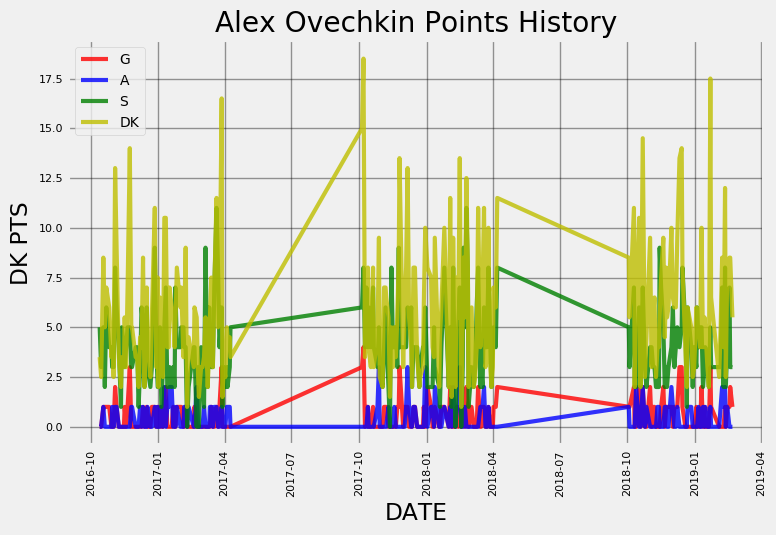

In [187]:
forecaster.plot_points(stats=['G', 'A', 'S', 'DK'], plot_type='basic')